In [13]:
# !pip install numpy
# !pip install conda
# !pip install openpyxl
# !pip install sklearn
# !pip install matplotlib
import pandas as pd
from google.colab import drive
import pandas as pd
import openpyxl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping


def calcmetrics(sim, obs):
    def RaiseErr(a,b):
        try:
            m=round(a/b,2)
        except ZeroDivisionError:
            m='NA'
        return m
    p_mean, p_std = sim.mean(), sim.std()
    o_mean, o_std = obs.mean(), obs.std()
    corr, p = stats.pearsonr(sim, obs)
    var_ratio = RaiseErr(p_std, o_std)
    bias_ratio = RaiseErr(p_mean, o_mean)
    if corr != 'NA' and var_ratio != 'NA' and bias_ratio != 'NA':
        kge = round(1 - np.sqrt((corr - 1) ** 2 + (var_ratio - 1) ** 2 + (bias_ratio - 1) ** 2), 2)
        R2 = round(corr ** 2, 2)
    else:
        kge = 'NA'
        R2 = 'NA'
    try:
        sim = (sim)
        obs = (obs)
        NSE = round(1 - (np.sum((sim - obs) ** 2) / np.sum((obs - np.mean(obs)) ** 2)), 2)
        if np.isinf(NSE):
            NSE = 'NA'
    except ZeroDivisionError:
        NSE = 'NA'
    return kge, NSE, R2

!gdown 1Myzzfn8DydDXgl0ehgDIV5n990D3qEge
!gdown 1yiBgUQYkCrChs4wPyS1ZWDPvcD7NYY9b

Downloading...
From: https://drive.google.com/uc?id=1Myzzfn8DydDXgl0ehgDIV5n990D3qEge
To: /content/Streamflow.xlsx
100% 110k/110k [00:00<00:00, 92.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yiBgUQYkCrChs4wPyS1ZWDPvcD7NYY9b
To: /content/prcp.xlsx
100% 173k/173k [00:00<00:00, 96.1MB/s]


            6892513
2000-01-31     0.00
2000-02-29     0.00
2000-03-31     0.00
2000-04-30     0.00
2000-05-31     0.00
...             ...
2020-08-31   919.68
2020-09-30   817.20
2020-10-31   291.13
2020-11-30   455.88
2020-12-31   391.69

[252 rows x 1 columns]


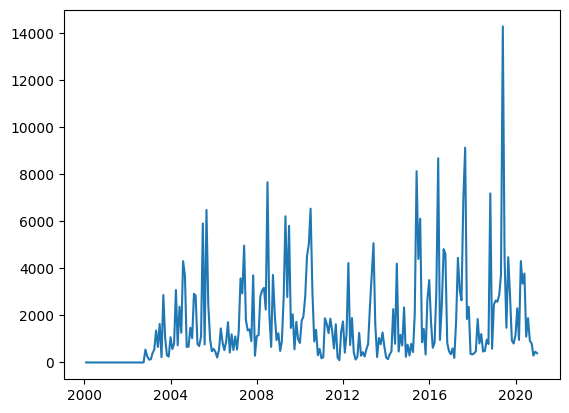

In [ ]:
### Read the data
#xtrain -> ysim, Xtest-> ypred

# drive.mount('/content/drive')
prcp = pd.read_excel('prcp.xlsx')
flow = pd.read_excel('Streamflow.xlsx')


flow.index=pd.date_range(start='2000-01-01',end='2020-12-31')
prcp.index=pd.date_range(start='2000-01-01',end='2020-12-31')
flow.index=pd.to_datetime(flow.index)
prcp.index=pd.to_datetime(prcp.index)

flow = flow.drop(columns='Unnamed: 0')
prcp = prcp.drop(columns='Unnamed: 0')

### Resample to monthly Daily = D, Monthly = M, Yearly = Y
flow = flow.resample('M').sum()
prcp = prcp.resample('M').sum()

print(flow)
plt.plot(flow)
plt.show()

#### First 3 years had little data so removed
flow=flow['2003':]
prcp=prcp['2003':]

###  Fill remaining nans with mean
prcp = prcp.mean(axis=1)
flow = flow.mean(axis=1)
flow[np.isnan(flow)]=np.nanmean(flow)
prcp[np.isnan(prcp)]=np.nanmean(prcp)


### Gaussian normalize the data as x' = x-mean/sigma
meanprcp = np.nanmean(prcp)
stdprcp = np.nanstd(prcp)
meanflow = np.nanmean(flow)
stdflow = np.nanstd(flow)

if(True):
    prcp = (prcp-meanprcp)/stdprcp
    flow = (flow-meanflow)/stdflow


prcp = pd.Series(prcp,name='prcp')
flow = pd.Series(flow,name='flow')
merged_df = pd.merge(prcp, flow, left_index=True, right_index=True)

X = merged_df[['prcp']]
y = merged_df['flow']

Training the models

Mean Squared Error: 0.5147726762248095


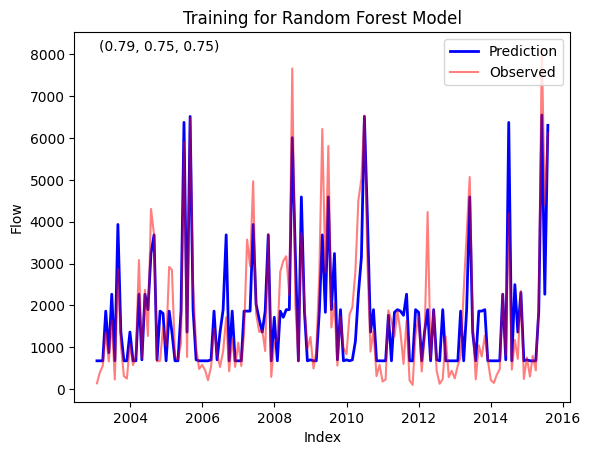

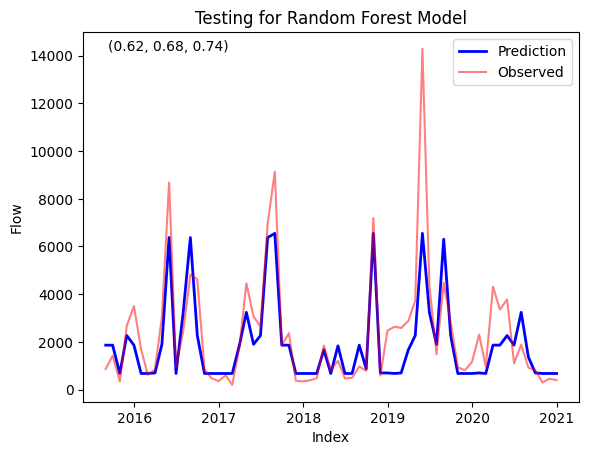

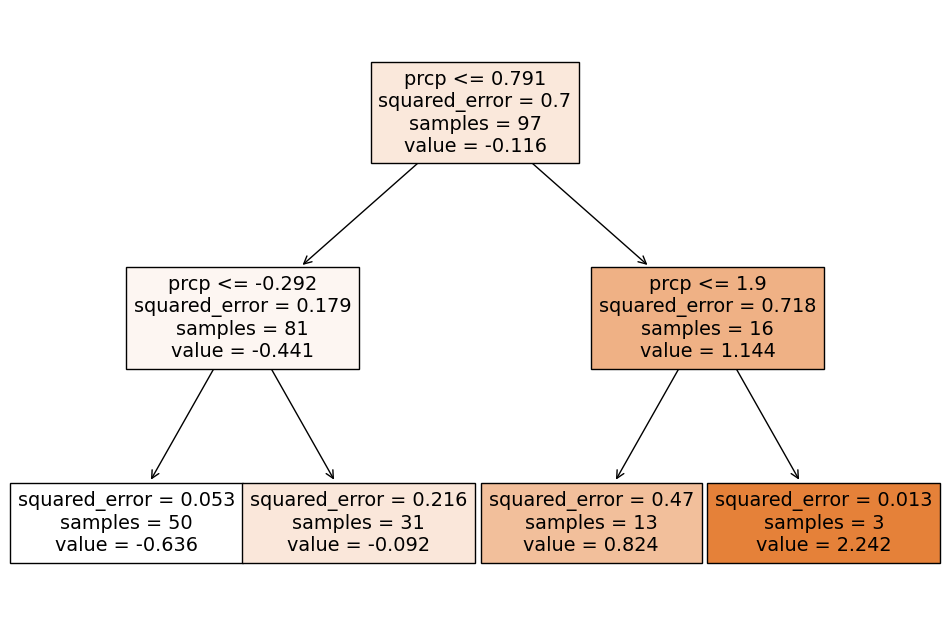

In [ ]:

### Train the Random Forest model
#### Training and test on RF model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
date_train = y_train.index
date_test = y_test.index


rf_model = RandomForestRegressor(n_estimators=50,max_depth=2)
rf_model.fit(X_train, y_train)
y_sim = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

#xtrain -> ysim, Xtest-> ypred
### Denormalize the prediction back
y_pred = y_pred*stdflow+meanflow
y_train = y_train*stdflow+meanflow
y_test = y_test*stdflow+meanflow
y_sim = y_sim*stdflow+meanflow

### Plot training
plt.plot(date_train, y_sim, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_train, y_train, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_sim,y_train),transform=plt.gca().transAxes)
plt.title('Training for Random Forest Model')
plt.show()


### Plot testing
plt.plot(date_test, y_pred, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_test, y_test, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_pred,y_test),transform=plt.gca().transAxes)
plt.title('Testing for Random Forest Model')
plt.show()

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import matplotlib.pyplot as plt

# Assuming you have trained a Random Forest model named rf_model
# Extract a single decision tree from the Random Forest
estimator = rf_model.estimators_[0]  # Choose the tree you want to visualize (e.g., the first tree)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(estimator, filled=True, feature_names=X.columns)  # Replace X.columns with your feature names
plt.show()


Mean Squared Error (Training): 0.039449353351319716
Mean Squared Error (Testing): 0.4253829892225268


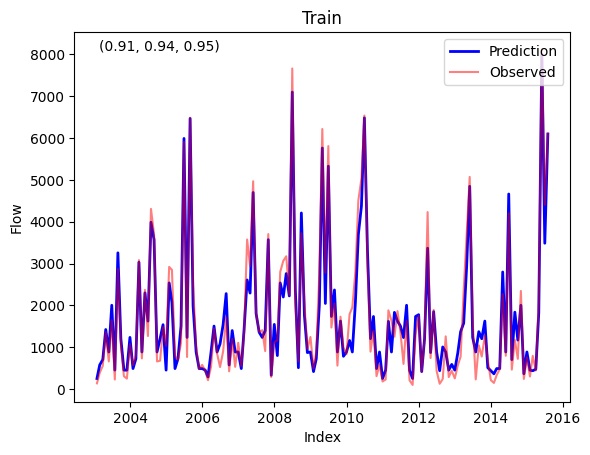

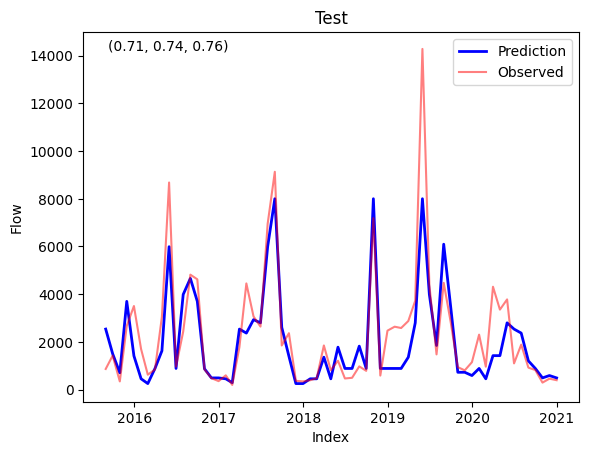

In [ ]:

# Training and Tetsing on Gradient Boosting XGBOOST algorithm

# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_sim = gb_model.predict(X_train)
y_pred = gb_model.predict(X_test)

# Evaluate the model's performance
mse_train = mean_squared_error(y_train, y_sim)
mse_test = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Training):", mse_train)
print("Mean Squared Error (Testing):", mse_test)

#xtrain -> ysim, Xtest-> ypred
### Denormalize the prediction back
y_pred = y_pred*stdflow+meanflow
y_train = y_train*stdflow+meanflow
y_test = y_test*stdflow+meanflow
y_sim = y_sim*stdflow+meanflow


### Plot training
plt.plot(date_train, y_sim, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_train, y_train, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_sim,y_train),transform=plt.gca().transAxes)
plt.title('Train')
plt.show()


### Plot testing
plt.plot(date_test, y_pred, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_test, y_test, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_pred,y_test),transform=plt.gca().transAxes)
plt.title('Test')
plt.show()


Epoch 1/50
12/12 [==============================] - 3s 62ms/step - loss: 0.5998 - val_loss: 0.8572
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.5403 - val_loss: 0.7660
Epoch 3/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4875 - val_loss: 0.6784
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 0.4348 - val_loss: 0.5953
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.3868 - val_loss: 0.5144
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.3405 - val_loss: 0.4404
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 0.3051 - val_loss: 0.3704
Epoch 8/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2715 - val_loss: 0.3194
Epoch 9/50
12/12 [==============================] - 0s 9ms/step - loss: 0.2490 - val_loss: 0.2842
Epoch 10/50
12/12 [==============================] - 0s 9ms/step - loss: 0.2373 - val_loss: 0.2575
Epoch 11/50
12/12 

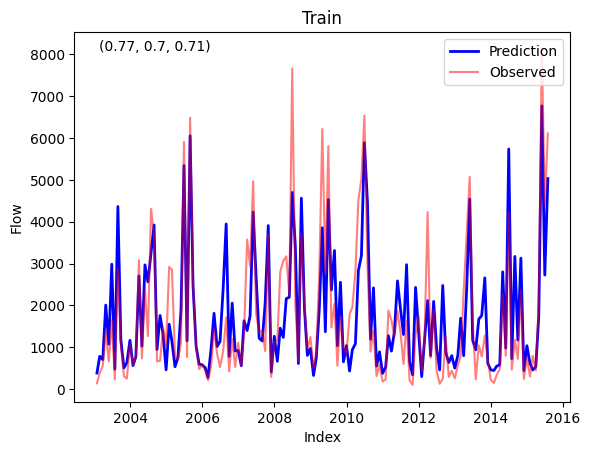

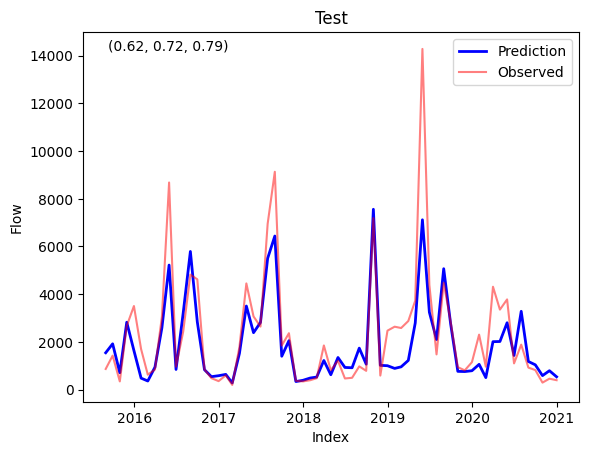

In [ ]:
# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42, shuffle=False)

# Reshape the data for LSTM input [samples, time steps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the training and testing data
y_sim = (model.predict(X_train_lstm)).flatten()
y_pred = (model.predict(X_test_lstm)).flatten()



# Evaluate the model's performance
mse_train = mean_squared_error(y_train, y_sim)
mse_test = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Training):", mse_train)
print("Mean Squared Error (Testing):", mse_test)

#xtrain -> ysim, Xtest-> ypred
### Denormalize the prediction back
y_pred = y_pred*stdflow+meanflow
y_train = y_train*stdflow+meanflow
y_test = y_test*stdflow+meanflow
y_sim = y_sim*stdflow+meanflow


### Plot training
plt.plot(date_train, y_sim, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_train, y_train, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_sim,y_train),transform=plt.gca().transAxes)
plt.title('Train')
plt.show()


### Plot testing
plt.plot(date_test, y_pred, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_test, y_test, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_pred,y_test),transform=plt.gca().transAxes)
plt.title('Test')
plt.show()


Mean Squared Error (Training): 0.2106101263568692
Mean Squared Error (Testing): 0.6299911098510221


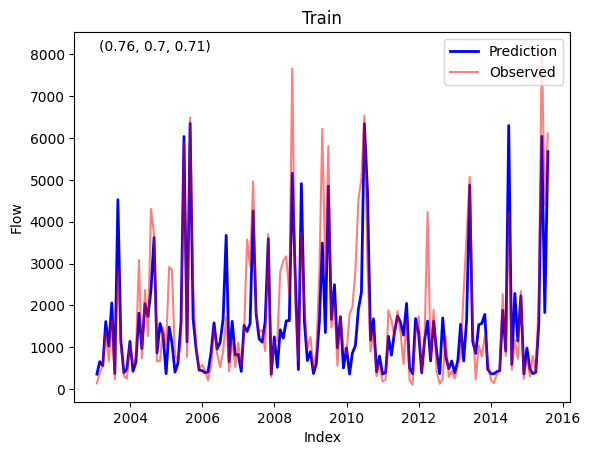

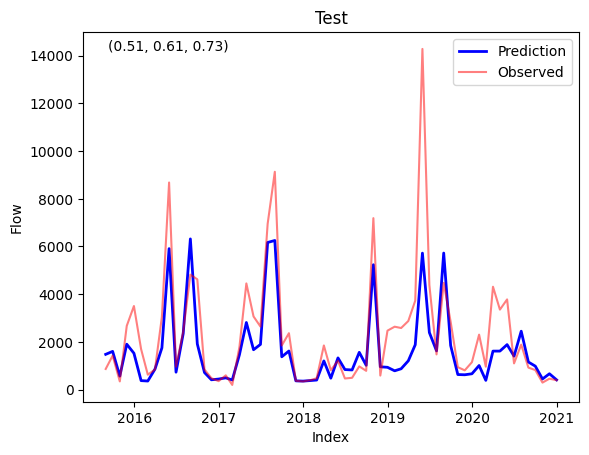

In [ ]:
#### SVR with shuffle off
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets (you can adjust the test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Define and train the SVM model
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')  # RBF kernel is commonly used for SVR
svm_model.fit(X_train, y_train)

# Make predictions on the testing data
y_sim = svm_model.predict(X_train)
y_pred = svm_model.predict(X_test)


# Evaluate the model's performance
mse_train = mean_squared_error(y_train, y_sim)
mse_test = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Training):", mse_train)
print("Mean Squared Error (Testing):", mse_test)


#xtrain -> ysim, Xtest-> ypred
### Denormalize the prediction back
y_pred = y_pred*stdflow+meanflow
y_train = y_train*stdflow+meanflow
y_test = y_test*stdflow+meanflow
y_sim = y_sim*stdflow+meanflow


### Plot training
plt.plot(date_train, y_sim, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_train, y_train, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_sim,y_train),transform=plt.gca().transAxes)
plt.title('Train')
plt.show()


### Plot testing
plt.plot(date_test, y_pred, color='blue', label='Prediction flow', linewidth=2)
plt.plot(date_test, y_test, color='red', label='Observed flow', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Flow')
plt.legend(['Prediction','Observed'], loc='upper right')
plt.text(0.05,0.95,calcmetrics(y_pred,y_test),transform=plt.gca().transAxes)
plt.title('Test')
plt.show()





In [ ]:
date_train

DatetimeIndex(['2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31',
               ...
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31'],
              dtype='datetime64[ns]', length=151, freq='M')